## Price movement from 1:00PM to 2:45PM

In [119]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

import warnings
warnings.filterwarnings('ignore')

In [120]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [121]:
### Ignore this year data => tranh over fitting
dataset = dataset[dataset.index < '2024-01-01 00:00:00']

In [122]:
data2 = dataset.copy()

In [123]:
def cal_first_close(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 915]
  if not tick.empty:
    return tick[0]


def cal_high_morning(tick):
  tick = tick[100*tick.index.hour+tick.index.minute < 1135]
  return tick.max()

def cal_high_afternoon(tick):
  tick = tick[100*tick.index.hour+tick.index.minute > 1255]
  return tick.max()


def cal_low_morning(tick):
  tick = tick[100*tick.index.hour+tick.index.minute < 1135]
  return tick.min()


def cal_low_afternoon(tick):
  tick = tick[100*tick.index.hour+tick.index.minute > 1255]
  return tick.min()

def cal_price(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1130]
  if not tick.empty:
    return tick[0]

In [124]:
data_tmp = dataset.copy()
data_tmp['first_close'] = data_tmp.Close
data_tmp['morning_high'] = data_tmp.High
data_tmp['morning_low'] = data_tmp.Low
data_tmp['afternoon_high'] = data_tmp.High
data_tmp['afternoon_low'] = data_tmp.Low
data_tmp['Day_Close'] = data_tmp.Close
data_tmp['price'] = data_tmp.Close
day_data = data_tmp.resample("D").agg({
    'first_close': cal_first_close,
    'morning_high':cal_high_morning,
    'morning_low': cal_low_morning,
    'afternoon_high':cal_high_afternoon,
    'afternoon_low': cal_low_afternoon,
    'price': cal_price,
    'Day_Close': 'last'
    })
day_data = day_data.dropna()

In [125]:
day_data

,first_close,morning_high,morning_low,afternoon_high,afternoon_low,price,Day_Close
Date,,,,,,,
2018-08-13,942.6,947.3,942.3,954.6,946.7,947.3,954.2
2018-08-14,956.9,957.3,952.1,961.8,952.5,954.3,959.3
2018-08-15,960.7,962.3,956.0,959.9,946.6,958.0,946.6
2018-08-16,942.1,943.5,935.5,947.3,936.5,938.1,947.0
2018-08-17,953.2,954.6,948.5,954.4,945.0,954.3,947.0
...,...,...,...,...,...,...,...
2023-12-25,1105.3,1115.0,1096.3,1119.2,1112.7,1113.0,1115.0
2023-12-26,1116.4,1117.0,1113.4,1121.5,1114.7,1116.2,1121.5
2023-12-27,1121.4,1124.8,1120.4,1126.2,1116.9,1121.2,1116.9


In [126]:
data = dataset.copy()

In [127]:
data = data.assign(time_d=pd.PeriodIndex(data.index, freq='1D').to_timestamp())
data = pd.merge(data, day_data, left_on="time_d", right_index=True, how="left")
data.drop(columns=['Volume', 'time_d'], inplace=True)

In [153]:
# Drop all morning data
data = data[100 * data.index.hour + data.index.minute > 1130]

In [129]:
# 0: not_min_max, 1: low area, 2: high area
data['in_area'] = data.apply(lambda r: 2 if r['afternoon_high'] - r['Close'] < 3 else (1 if r['Close'] - r['afternoon_low'] < 3 else 0), axis=1)

In [154]:
data

,Open,High,Low,Close,first_close,morning_high,morning_low,afternoon_high,afternoon_low,price,Day_Close,in_area,mom_y,body_rate,prev_high_rate,prev_low_rate,next_high_rate,next_low_rate,body_rate_group,mom_y_group
Date,,,,,,,,,,,,,,,,,,,,
2018-08-13 13:00:00,947.5,947.9,947.2,947.5,942.6,947.3,942.3,954.6,946.7,947.3,954.2,1,NaN,0.980000,-0.211082,-5.488127,7.706112,-0.633379,"(0.81, 1.0]",NaN
2018-08-13 13:05:00,947.6,948.8,947.6,948.0,942.6,947.3,942.3,954.6,946.7,947.3,954.2,1,-0.649759,1.080000,-0.738397,-6.012658,7.706112,-0.633379,"(1.0, 1.323]","(-0.713, -0.523]"
2018-08-13 13:10:00,948.0,948.7,947.3,948.7,942.6,947.3,942.3,954.6,946.7,947.3,954.2,1,-0.576399,1.220000,-1.475704,-6.746074,7.706112,-0.633379,"(1.0, 1.323]","(-0.713, -0.523]"
2018-08-13 13:15:00,948.5,948.9,947.8,948.2,942.6,947.3,942.3,954.6,946.7,947.3,954.2,1,-0.628799,1.120000,-0.949167,-6.222316,7.706112,-0.633379,"(1.0, 1.323]","(-0.713, -0.523]"
2018-08-13 13:20:00,948.0,948.5,947.7,947.7,942.6,947.3,942.3,954.6,946.7,947.3,954.2,1,-0.681199,1.020000,-0.422074,-5.698006,7.706112,-0.633379,"(1.0, 1.323]","(-0.713, -0.523]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29 14:15:00,1133.8,1136.5,1132.4,1132.9,1134.5,1138.0,1132.0,1139.5,1130.9,1137.2,1134.6,1,-0.149833,-0.266667,4.501721,-0.794421,2.022511,-5.539923,"(-0.348, -0.236]","(-0.207, -0.138]"
2023-12-29 14:20:00,1132.4,1133.7,1131.5,1133.3,1134.5,1138.0,1132.0,1139.5,1130.9,1137.2,1134.6,1,-0.114578,-0.200000,4.147181,-1.147093,2.022511,-5.539923,"(-0.236, -0.123]","(-0.138, -0.079]"
2023-12-29 14:25:00,1133.5,1134.9,1132.2,1133.9,1134.5,1138.0,1132.0,1139.5,1130.9,1137.2,1134.6,0,-0.061696,-0.100000,3.615839,-1.675633,2.022511,-5.539923,"(-0.123, -0.0056]","(-0.079, -0.0267]"


In [130]:
# mom_y = momentum_yesterday
data['mom_y'] = 100 * (data.Close - data.Day_Close.shift(1)) / data.Day_Close.shift(1)
data['body_rate'] = (data.Close - data.first_close) / (data.morning_high - data.morning_low)
data['prev_high_rate'] = 1000 * (data.morning_high - data.Close) / data.Close
data['prev_low_rate'] = 1000 * (data.morning_low - data.Close) / data.Close
data['next_high_rate'] = 1000 * (data.afternoon_high - data.price) / data.price
data['next_low_rate'] = 1000 * (data.afternoon_low - data.price) / data.price

In [131]:
# Think about drop the outlier data

In [132]:
working_group_high = data[data.in_area==2]
working_group_low = data[data.in_area==1]
working_group_none = data[data.in_area==0]

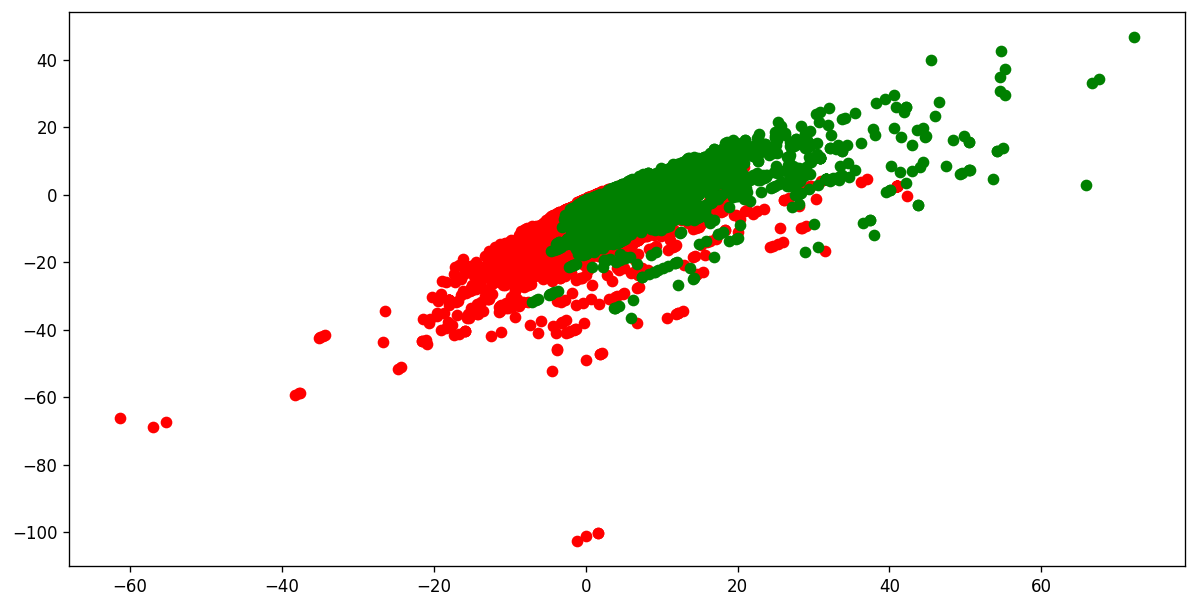

In [151]:
plt.scatter(working_group_high['prev_high_rate'], working_group_high['prev_low_rate'], c='red')
plt.scatter(working_group_low['prev_high_rate'], working_group_low['prev_low_rate'], c='green')

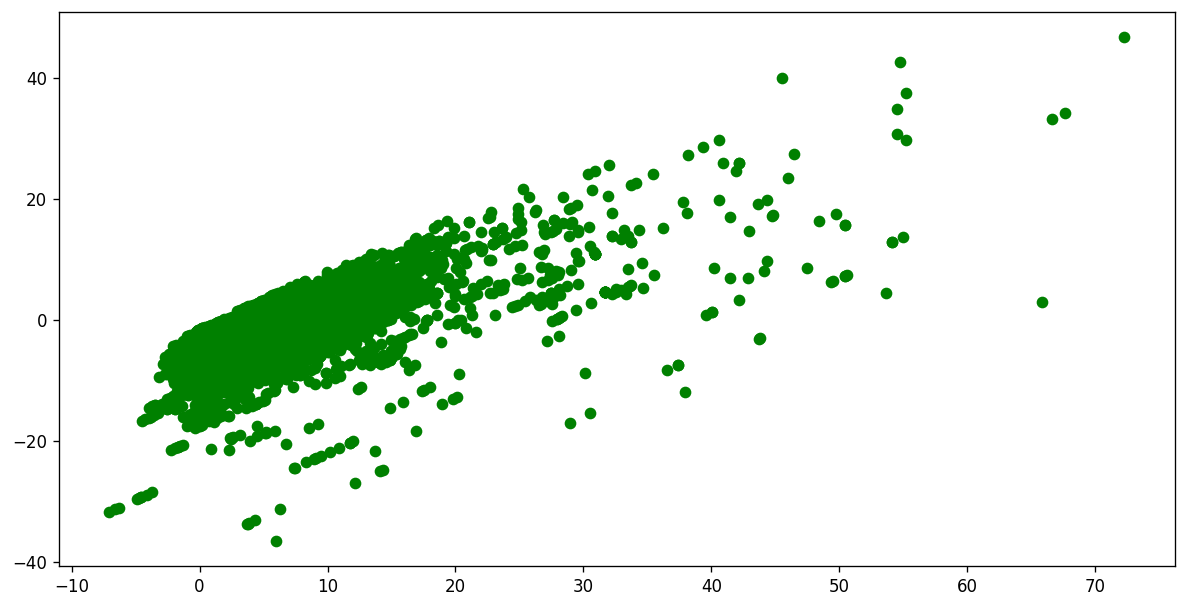

In [134]:
plt.scatter(working_group_low['prev_high_rate'], working_group_low['prev_low_rate'], c='green')

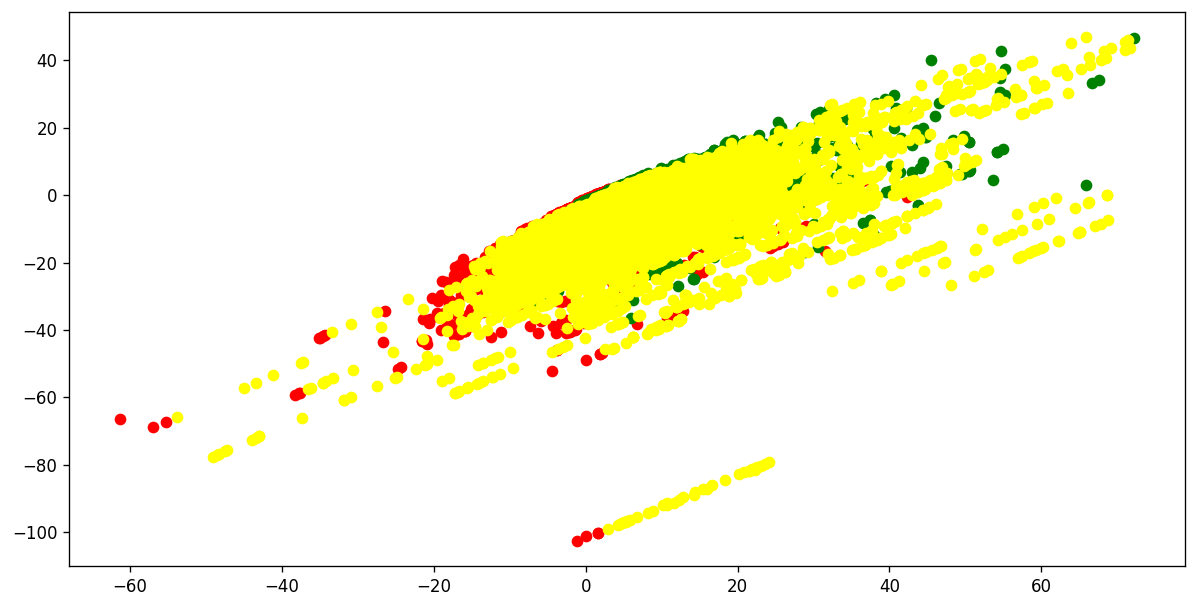

In [152]:
plt.scatter(working_group_high['prev_high_rate'], working_group_high['prev_low_rate'], c='red')
plt.scatter(working_group_low['prev_high_rate'], working_group_low['prev_low_rate'], c='green')
plt.scatter(working_group_none['prev_high_rate'], working_group_none['prev_low_rate'], c='yellow')

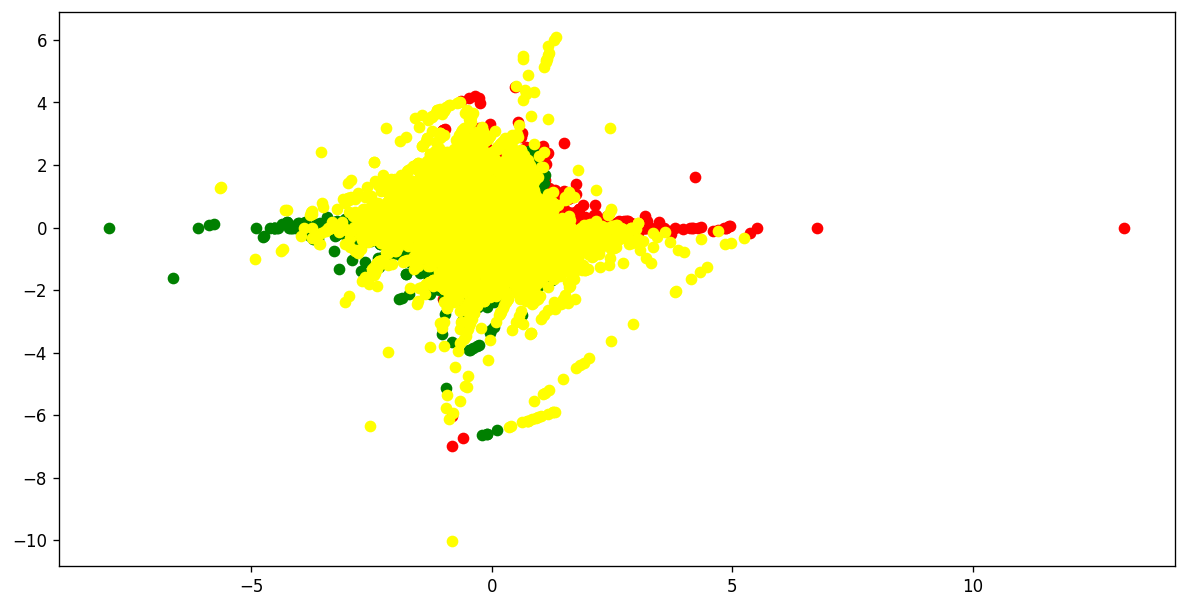

In [136]:
plt.scatter(working_group_high['body_rate'], working_group_high['mom_y'], c='red')
plt.scatter(working_group_low['body_rate'], working_group_low['mom_y'], c='green')
plt.scatter(working_group_none['body_rate'], working_group_none['mom_y'], c='yellow')

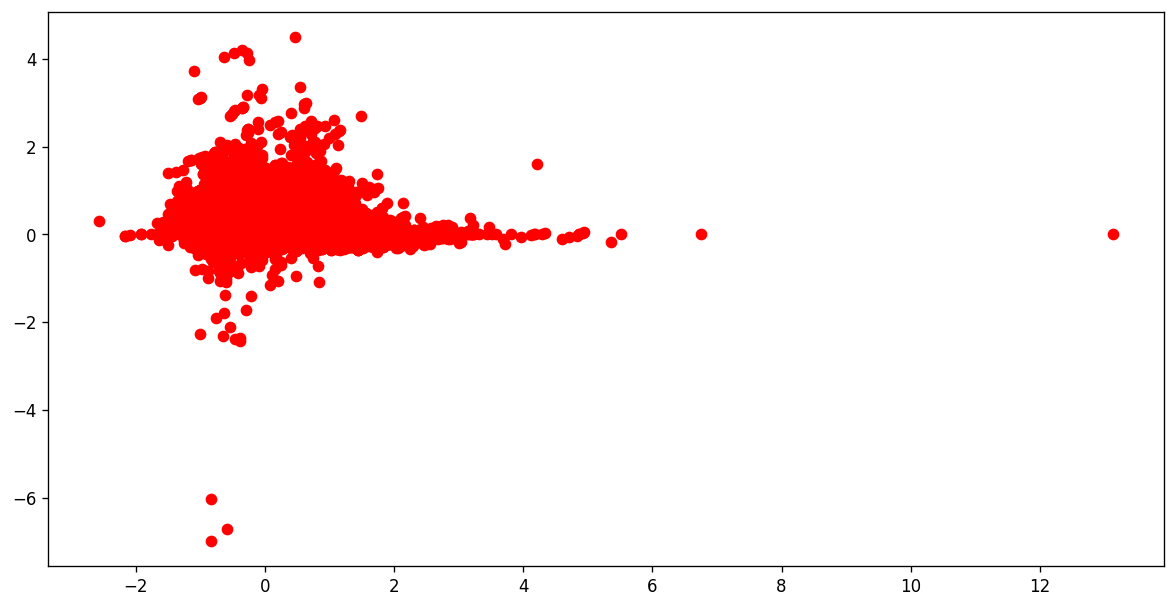

In [150]:
plt.scatter(working_group_high['body_rate'], working_group_high['mom_y'], c='red')

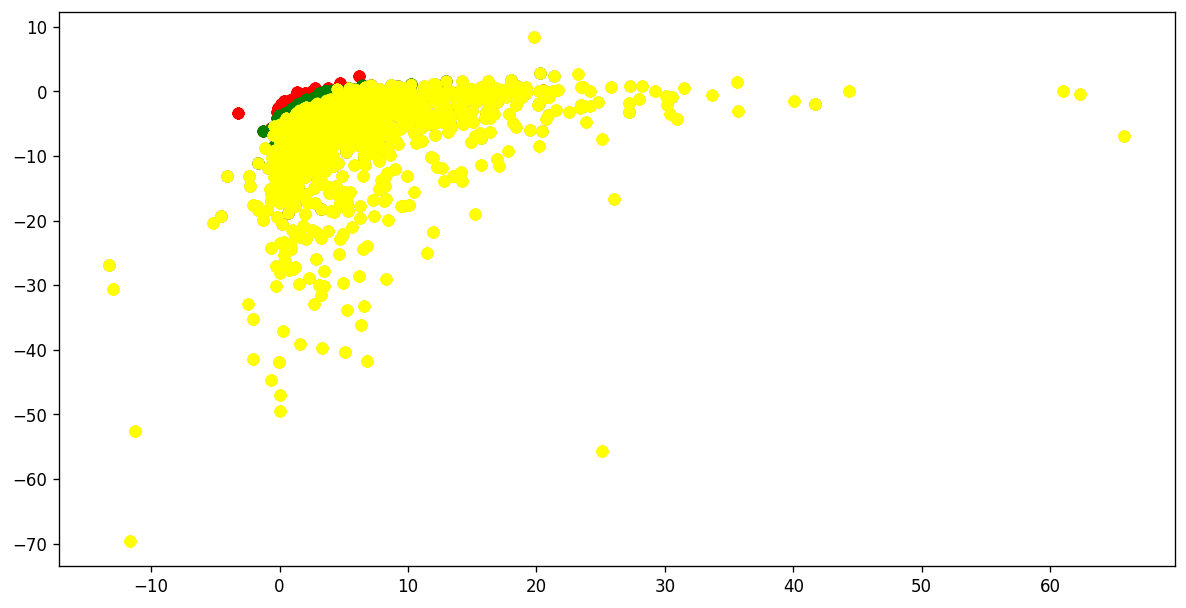

In [137]:
plt.scatter(working_group_high['next_high_rate'], working_group_high['next_low_rate'], c='red')
plt.scatter(working_group_low['next_high_rate'], working_group_low['next_low_rate'], c='green')
plt.scatter(working_group_none['next_high_rate'], working_group_none['next_low_rate'], c='yellow')

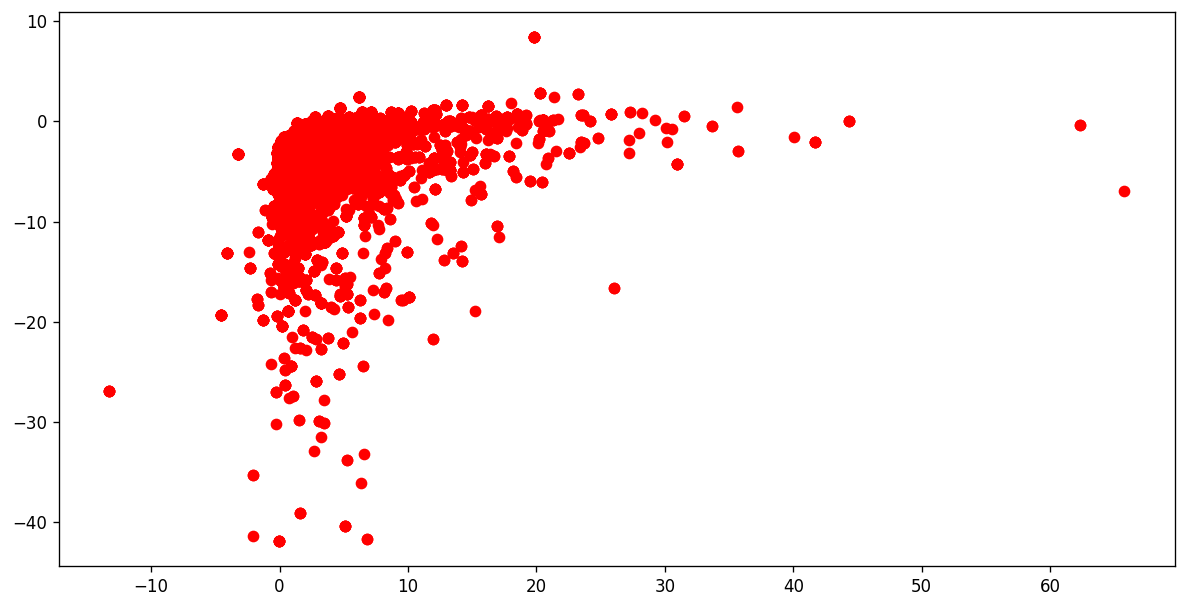

In [138]:
plt.scatter(working_group_high['next_high_rate'], working_group_high['next_low_rate'], c='red')

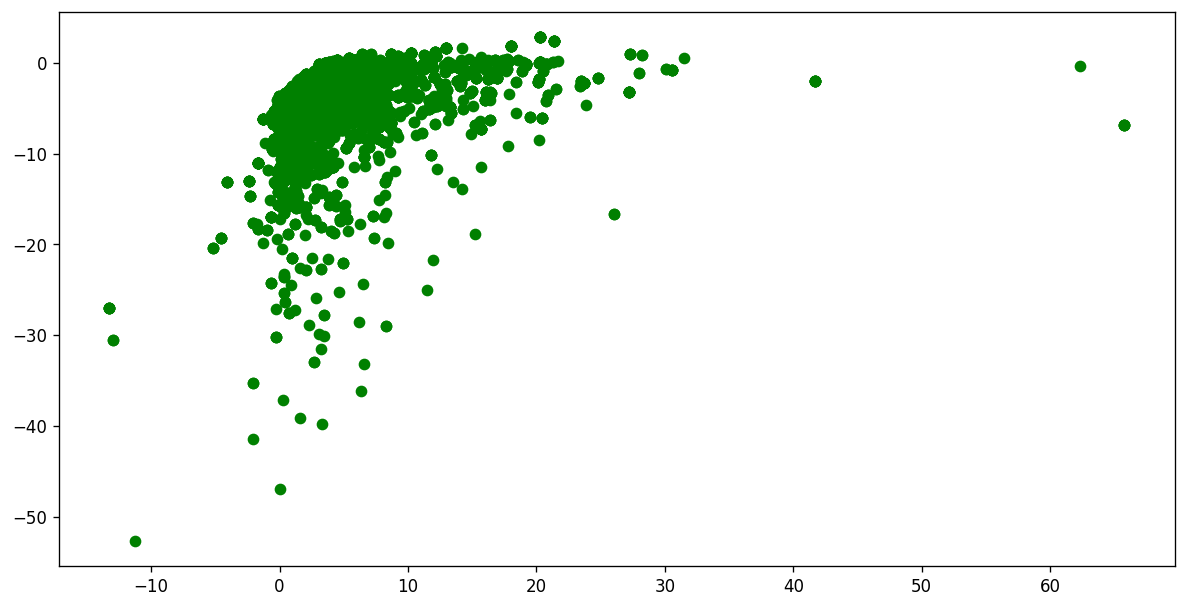

In [139]:
plt.scatter(working_group_low['next_high_rate'], working_group_low['next_low_rate'], c='green')

### Body rate - distribution

In [140]:
data['body_rate'].describe()

count    26600.000000
mean        -0.025629
std          0.907454
min         -7.951807
25%         -0.574529
50%         -0.005604
75%          0.555556
max         13.139535
Name: body_rate, dtype: float64

In [141]:
data['body_rate_group'] = pd.qcut(data.body_rate, 20)

### Momentum today-yesterday - distribution

In [142]:
data['mom_y'].describe()

count    26599.000000
mean         0.015835
std          0.747128
min        -10.023148
25%         -0.288351
50%          0.000000
75%          0.290493
max          6.088710
Name: mom_y, dtype: float64

In [143]:
data['mom_y_group'] = pd.qcut(data.mom_y, 20)

### Next high_rate & low_rate - distribution

In [144]:
data['next_high_rate'].describe()

count    26600.000000
mean         5.813528
std          6.750613
min        -13.255416
25%          1.489269
50%          4.017857
75%          7.700033
max         65.745652
Name: next_high_rate, dtype: float64

In [145]:
data['next_low_rate'].describe()

count    26600.000000
mean        -6.141781
std          7.356836
min        -69.601329
25%         -7.977475
50%         -3.951768
75%         -1.588743
max          8.405245
Name: next_low_rate, dtype: float64